## Helper Notebook to Inspect  PNW Dataset





- All waveform data downloaded from [IRIS DMC](https://ds.iris.edu/ds/nodes/dmc/).
- Events and phase information are downloaded from [ANSS/ComCat](https://earthquake.usgs.gov/data/comcat/) using [libcomcat](https://github.com/usgs/libcomcat).

- Please download datasets manually from Goole Drive. See link below.
---
 ##### Yiyu Ni (niyiyu@uw.edu)
 ##### Earth and Space Sciences
 ##### University of Washington

In [ ]:
# some modules are not intalled in google colab by default.
pip install obspy scipy

In [ ]:
# suppress pandas future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import h5py
import obspy
import pandas as pd
import numpy as np

# plotting lib
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# datetime interaction
from datetime import datetime
from datetime import timedelta as dt
from obspy.core.utcdatetime import UTCDateTime

# lib for comcat access
# ... if you work in Google Colab, I haven't find a way to install libcomcat 
# ... through pip. Please skip this part.

# from libcomcat.dataframes import get_phase_dataframe
# from libcomcat.search import get_event_by_id

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def interactive_plotting(df, index, seconds_before = 3, seconds_after = 3, apply_filter = None, freq = None, freqmax = None, freqmin = None):
    source_id = df.iloc[index]['source_id']
    net = df.iloc[index]['station_network_code']
    sta = df.iloc[index]['station_code']
    loc =  df.iloc[index]['station_location_code']
    cha = df.iloc[index]['trace_channel']
    sample_p = df.iloc[index]['trace_P_arrival_sample']
    sample_s = df.iloc[index]['trace_S_arrival_sample']
    trace_starttime = df.iloc[index]['trace_start_time']
    sample_rate = df.iloc[index]['trace_sampling_rate_hz']
    
    tn = df.iloc[index]['trace_name']
    bucket, narray = tn.split('$')
    x, y, z = iter([int(i) for i in narray.split(',:')])
    data = f['/data/%s' % bucket][x, :y, :z]

    stream = obspy.Stream()
    for i in range(3):
        tr = obspy.Trace()
        tr.data = data[i, :]
        tr.stats.sampling_rate = df.iloc[index]['trace_sampling_rate_hz']
        stream.append(tr)
    
    if apply_filter == 'bandpass':
        stream.filter(apply_filter, freqmin = freqmin, freqmax = freqmax)
    elif apply_filter is not None:
        stream.filter(apply_filter, freq = freq)

    starttime = datetime.utcfromtimestamp(UTCDateTime(trace_starttime).timestamp)
    x = [starttime + dt(seconds = i/sample_rate) for i in np.arange(15001)]
    p_time = [(starttime + dt(seconds = sample_p/sample_rate)) for _ in range(10)]
    s_time = [(starttime + dt(seconds = sample_s/sample_rate)) for _ in range(10)]
    plt.figure(figsize = (12, 10), dpi = 80)
    myFmt = mdates.DateFormatter('%X.%f\n%Y/%m/%d')
    plt.subplots_adjust(hspace = 0.2)
    plt.subplot(2, 1, 1)
    plt.title("%s.%s..%s" % (net, sta, cha), fontsize = 20)
    plt.plot(x, np.array(stream).T, '.-', markersize = 2, linewidth = 1)
    plt.grid(True)
    plt.plot(p_time, np.linspace(-data.max(), data.max(), 10), 
             'r--', label = 'PNSN P Pick', linewidth = 2)
    plt.gca().xaxis.set_major_formatter(myFmt)
    plt.legend()
    plt.xlim([p_time[0] - dt(seconds = seconds_before),  
              p_time[0] + dt(seconds = seconds_after)])   # Only look at seconds before/after arrival


    plt.subplot(2, 1, 2)
    plt.plot(x, np.array(stream).T, '.-', markersize = 2, linewidth = 1)
    plt.grid(True)
    plt.plot(s_time, np.linspace(-data.max(), data.max(), 10), 
             'k--', label = 'PNSN S Pick', linewidth = 2)
    plt.gca().xaxis.set_major_formatter(myFmt)
    plt.legend()
    plt.xlim([s_time[0] - dt(seconds = seconds_before),  
              s_time[0] + dt(seconds = seconds_after)])   # Only look at seconds before/after arrival

## Load the PNW dataset
- waveform (waveforms.hdf5 ~35G): https://drive.google.com/file/d/1Ktee6VV4Nz6I0oo0IjGiW8BX_Zzb7wyE/view?usp=sharing
- metadata (metadata.csv ~19MB): https://drive.google.com/file/d/1TcG1Ey5pxMEZatPXiHufBK0XC_SgO1Bl/view?usp=sharing
- This dataset follows the structure of [seisbench](https://seisbench.readthedocs.io/en/latest/). See [here](https://seisbench.readthedocs.io/en/latest/pages/data_format.html) to learn more about the  file structure.

In [ ]:
# be sure to check the location of waveforms and metadata
path_to_data = "/content/drive/Shareddrives/PNSN_ML/PNW/Dataset/"

f = h5py.File(path_to_data + "waveforms.hdf5", "r")
df = pd.read_csv(path_to_data + "metadata.csv")
df.insert(0, "index", range(len(df)))
df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,split,source_magnitude,station_network_code,trace_channel,...,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,CODE,trace_S-P_arrival_sample
0,0,uw10516388,2000-12-16T17:41:52.090000Z,47.594000,-122.585667,25.571,dev,2.20,UW,EHZ,...,0.0,0.0,0.0,"bucket4$0,:3,:15001",100.0,2000-12-16T17:41:02.090000Z,7834.0,6637.0,uw10516388UWRER,NaN
1,1,uw10516388,2000-12-16T17:41:52.090000Z,47.594000,-122.585667,25.571,train,2.20,UW,EHZ,...,0.0,0.0,0.0,"bucket4$1,:3,:15001",100.0,2000-12-16T17:41:02.090000Z,7858.0,6642.0,uw10516388UWRCS,NaN
2,2,uw10516388,2000-12-16T17:41:52.090000Z,47.594000,-122.585667,25.571,train,2.20,UW,EHZ,...,0.0,0.0,0.0,"bucket10$0,:3,:15001",100.0,2000-12-16T17:41:02.090000Z,8496.0,7020.0,uw10516388UWWPW,NaN
3,3,uw10516388,2000-12-16T17:41:52.090000Z,47.594000,-122.585667,25.571,train,2.20,UW,EHZ,...,0.0,0.0,0.0,"bucket8$0,:3,:15001",100.0,2000-12-16T17:41:02.090000Z,7797.0,6607.0,uw10516388UWFMW,NaN
4,4,uw10516388,2000-12-16T17:41:52.090000Z,47.594000,-122.585667,25.571,train,2.20,UW,EHZ,...,0.0,0.0,0.0,"bucket6$0,:3,:15001",100.0,2000-12-16T17:41:02.090000Z,8881.0,7215.0,uw10516388UWELK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103952,103952,uw61565622,2020-01-01T11:04:33.210000Z,47.568667,-122.797000,18.470,train,1.22,PB,EHZ,...,0.0,0.0,0.0,"bucket4$10587,:3,:15001",100.0,2020-01-01T11:03:43.210000Z,7178.0,6232.0,uw61565622PBB941,NaN
103953,103953,uw61565537,2020-01-01T03:44:56.640000Z,46.848500,-121.757000,0.430,train,0.97,UW,HHZ,...,0.0,0.0,0.0,"bucket2$10544,:3,:15001",100.0,2020-01-01T03:44:06.640000Z,5125.0,5067.0,uw61565537UWRCM,NaN
103954,103954,uw61565537,2020-01-01T03:44:56.640000Z,46.848500,-121.757000,0.430,train,0.97,UW,EHZ,...,0.0,0.0,0.0,"bucket1$10650,:3,:15001",100.0,2020-01-01T03:44:06.640000Z,5136.0,5069.0,uw61565537UWSTAR01,NaN
103955,103955,uw61565537,2020-01-01T03:44:56.640000Z,46.848500,-121.757000,0.430,test,0.97,UW,EHZ,...,0.0,0.0,0.0,"bucket3$10529,:3,:15001",100.0,2020-01-01T03:44:06.640000Z,5132.0,5070.0,uw61565537UWRCS,NaN


## Do some stream selection only if necessary

In [ ]:
df_filt = df

# df_filt = df_filt[df_filt['source_id'] == 'uw61631152']      # select a source id
df_filt = df_filt[df_filt['source_magnitude'] >= 5]          # select filter out magnitude
# df_filt = df_filt[df_filt['station_network_code'] == 'UW']   # select network code
# df_filt = df_filt[df_filt['station_code'] == 'VLL']          # select station code

df_filt

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,split,source_magnitude,station_network_code,trace_channel,...,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,CODE,trace_S-P_arrival_sample
38083,38083,uw60507871,2013-02-27T22:25:44.340000Z,43.103,-126.849667,4.182,test,5.1,PB,EHZ,...,0.0,0.0,0.0,"bucket1$3925,:3,:15001",100.0,2013-02-27T22:24:54.340000Z,11537.0,8539.0,uw60507871PBB032,NaN


## Specify an index by looking at the "index" column of filtered dataframe

In [ ]:
# specify a index:
index = 38082

# ... or randomly look at all data set:
# index = np.random.randint(103957)

df.iloc[index]

index                                             38082
source_id                                    uw60508031
source_origin_time          2013-02-28T22:35:30.890000Z
source_latitude_deg                           49.504833
source_longitude_deg                        -120.529167
source_depth_km                                   -0.54
split                                              test
source_magnitude                                   2.38
station_network_code                                 UW
trace_channel                                       EHZ
station_code                                        CBS
station_location_code                               NaN
station_latitude_deg                                0.0
station_longitude_deg                               0.0
station_elevation_m                                 0.0
trace_name                       bucket9$3926,:3,:15001
trace_sampling_rate_hz                            100.0
trace_start_time            2013-02-28T22:34:40.

## Interactive plotting of stream
**Note that interactive plotting is not available at Google Colab**

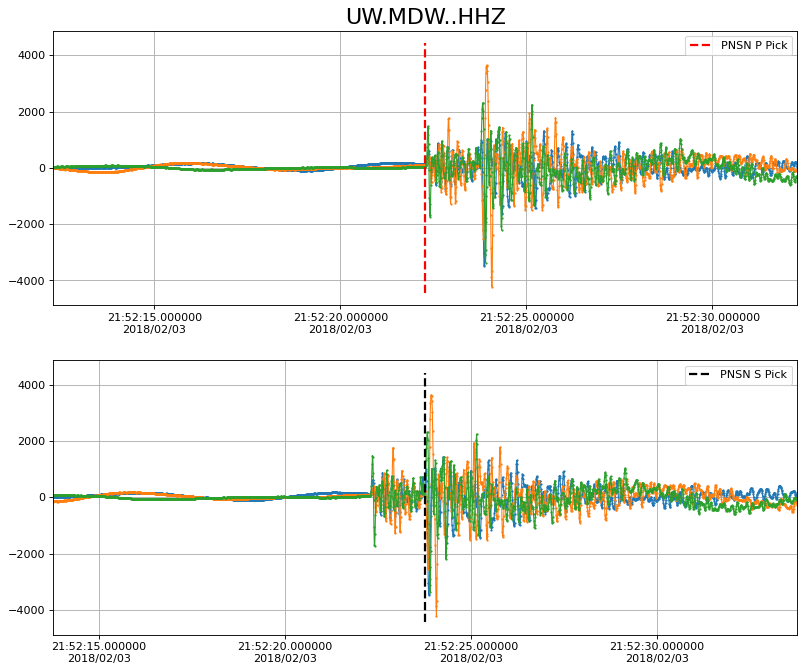

In [ ]:
# %matplotlib notebook

index = np.random.randint(103957)

interactive_plotting(df, index, seconds_before = 10, seconds_after = 10, apply_filter = 'lowpass',  freq = 10)



## Use ComCat Python interface to check the arrivals from ANSS

In [ ]:
source_id = df.iloc[index]['source_id']
detail = get_event_by_id(source_id, includesuperseded=False)
df_cc = get_phase_dataframe(detail, catalog='uw')
df_cc[df_cc['Channel'].str.contains(df.iloc[index]['station_code'])]

NameError: ignored